# 1110c - 2d, MR 100, no HE

In [1]:
from adios2toolspy import SuperCell, Particles, Fields
from h5toolspy import getH5Grid, selectSubSpace
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline 
plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
class DistFunc:
    def __init__(self, hist):
        self._hist = hist
        self._counts = hist[0]
        self._bins = hist[1][1:]
        #print(f'DistFunc: {sum(hist[0])} particles')
        
    def plot(self, ax=None, **kwargs):
        if not ax: ax = plt.gca()
            
        ax.plot(self.bins(), self._hist[0], **kwargs)
        ax.set_yscale('log')
        #ax.set_xlabel('$v^2$')
        ax.set_ylabel('count')
        
    def plot_fit(self, A, T, ax=None):
        if not ax: ax = plt.gca()
            
        ax.plot(self.bins(), A*np.exp(-self.bins()/T))

    def bins(self):
        return .5 * (self._hist[1][:-1] + self._hist[1][1:])
    
def make_DistFunc(path, species, patch):
    SC = SuperCell(path, patch, patches=numPatches, species=species, cellsPerPatch=cellsPerPatch)
    h = SC.histogramV(nbins, log=True, dim='s')
    return DistFunc(h)

class Domain:
    def __init__(self, L, gdims):
        self.L = np.asarray(L)
        self.gdims = np.asarray(gdims, dtype=int)
        self.dx = self.L / self.gdims
        self.corner = -.5 * self.L
        self.y = np.linspace(self.corner[1], self.corner[1] + self.L[1], self.gdims[1], endpoint=False)
        self.z = np.linspace(self.corner[2], self.corner[2] + self.L[2], self.gdims[2], endpoint=False)
        
    def set_selection(self, start, count):
        self.start = np.asarray(start)
        self.count = np.asarray(count)
        self.yy = self.y[start[1]:start[1]+count[1]]
        self.zz = self.z[start[2]:start[2]+count[2]]
        
def plot_fld(domain, fld, **kwargs):
    plt.xlabel('y')
    plt.ylabel('z')
    plt.pcolormesh(domain.yy, domain.zz, fld, shading='gouraud', **kwargs)
    plt.gca().set_aspect('equal')

def plot_boxes(domain, patches):
    for patch in patches:
        selectSubSpace(domain.corner[1] + patch[1] * domain.dx[1],
                       domain.corner[2] + patch[2] * domain.dx[2],
                       numPatches=numPatches,
                       cellsPerPatch=domain.dx[1]*cellsPerPatch)

class Reader:
    def __init__(self, domain, root, what, time):
        self._domain = domain
        self._root = root
        self._what = what
        self._time = time
        
    def read(self, fldname):
        data = getH5Grid(self._root, self._what, fldname, self._time,
                         corner=domain.start, dims=domain.count)
        return data[:,:,0]



In [3]:
root = '/gpfs/alpine/proj-shared/fus137/kaig1/flatfoil-20201110g/'

domain = Domain([1, 2*800, 2*3*800], [1, 2*2*800, 2*2*3*800])
domain.set_selection(start=[0, 0, 2*2400], count=[1, 2*1600, 2*1200])

numPatches=1
cellsPerPatch=32
time = -1
times = [148000]
nbins = 100
specs = {'e': 'electron'}#, 'he': 'electron_he'}

In [4]:
nrows = 4
ncols = 5

rect = np.array([0, -800 + 384, 576])
patches = []
for j in range(nrows):
    for i in range(ncols):
        patch = rect + (0, 64 * i, 64 * j)
        b = ((patch - domain.corner) / domain.dx + .5).astype(int)
        b[0] = 0 # FIXME
        patches.append(b)


In [5]:
pfd, pfdm = Reader(domain, root, 'pfd', time), Reader(domain, root, 'pfd_moments', time)
bx = pfd.read('hx_fc')
n_e = -pfdm.read('rho_e')
txx_e, tyy_e, tzz_e = [pfdm.read(fld) for fld in ('txx_e', 'tyy_e', 'tzz_e')]
t_e = (1/3) * (txx_e + tyy_e + tzz_e) / n_e
bx.shape

Loading hx_fc from File: pfd.148000.xdmf
Loading rho_e from File: pfd_moments.148000.xdmf
Loading txx_e from File: pfd_moments.148000.xdmf
Loading tyy_e from File: pfd_moments.148000.xdmf
Loading tzz_e from File: pfd_moments.148000.xdmf


(2400, 3200)

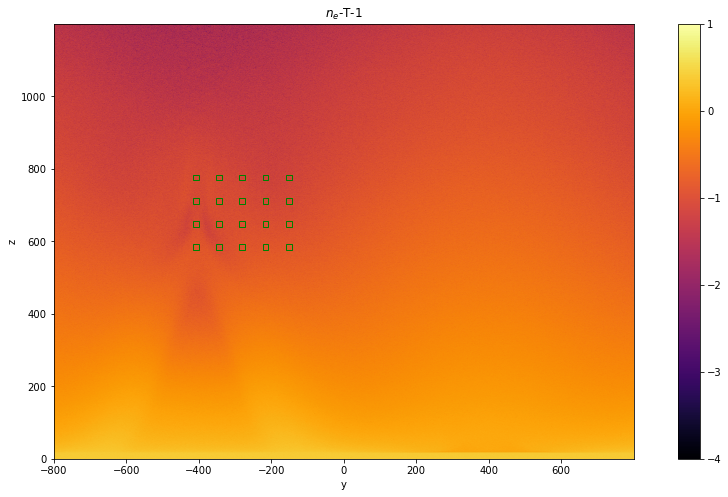

In [6]:
plt.title(f'$n_e$-T{time}')
plot_fld(domain, np.log10(n_e), cmap='inferno')
plt.clim(-4, 1)
plt.colorbar()
plot_boxes(domain, patches)

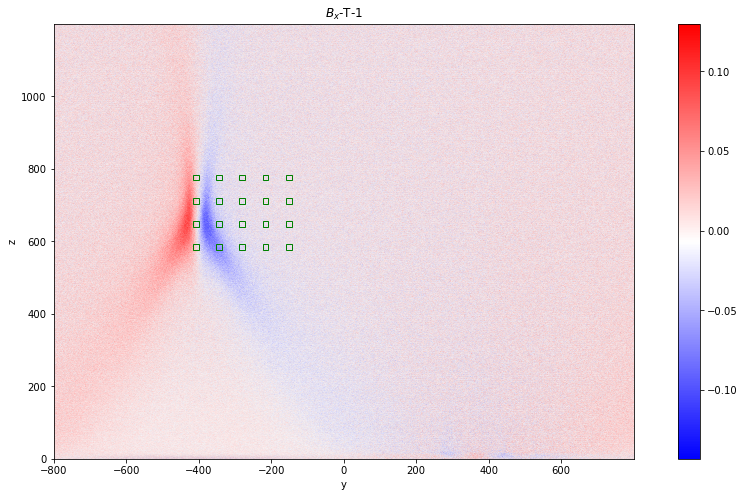

In [7]:
plt.title(f'$B_x$-T{time}')
plot_fld(domain, bx, cmap='bwr')

plt.colorbar()
plot_boxes(domain, patches)

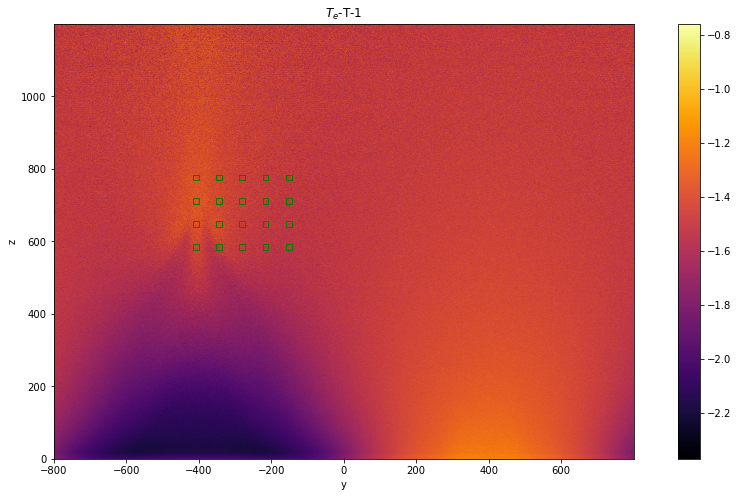

In [8]:
plt.title(f'$T_e$-T{time}')
plot_fld(domain, np.log10(t_e), cmap='inferno')
#plot_fld(domain, t_e, cmap='inferno')
#plt.clim(-4, 1)
plt.colorbar()
plot_boxes(domain, patches)


In [9]:
dfs = {}
for s, species in specs.items():
    d = []
    for t in times:
        path = os.path.join(root, f'checkpoint_{t}.bp')
        d.append([make_DistFunc(path, species, patch) for patch in patches])

    dfs[s] = d

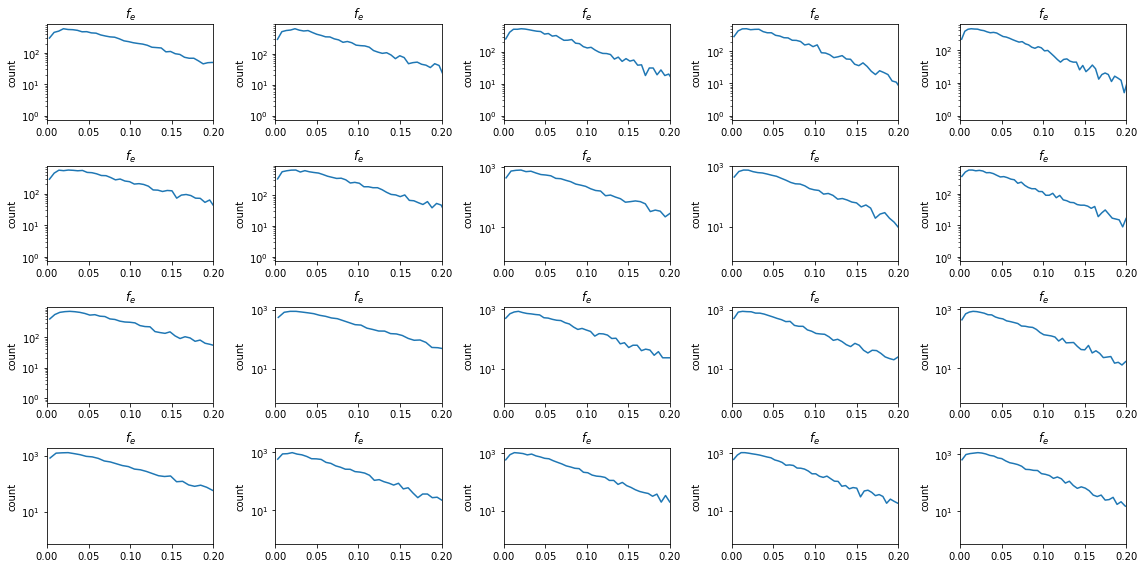

In [10]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
t = 0
for j in range(nrows):
    for i in range(ncols):
        ax = axes[j, i]
        idx = (nrows - j - 1) * ncols + i
        dfs['e'][t][idx].plot(ax=ax)
        ax.set_title('$f_e$')
        #ax.set_ylim(.5, 1e3)
        ax.set_xlim(0, .2)
plt.tight_layout()

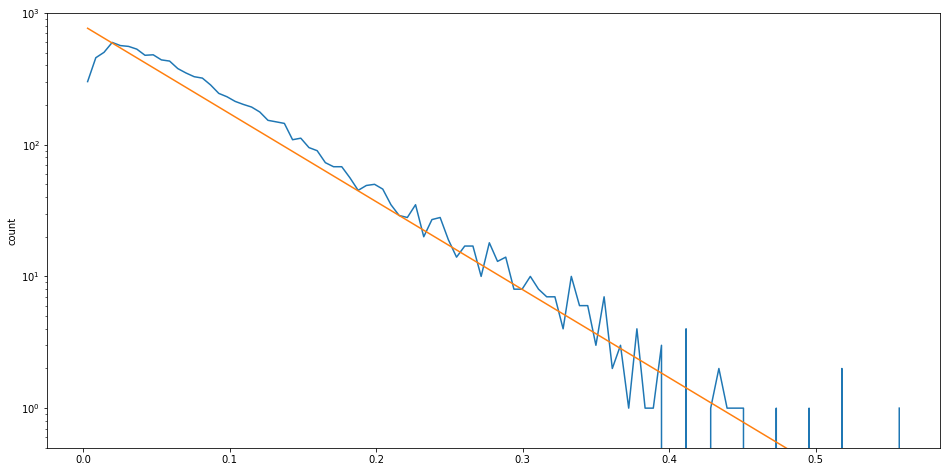

In [17]:
df = dfs['e'][0][3*ncols+0]
df.plot()
df.plot_fit(8e2, .065)
plt.ylim(.5, 1e3);